#### Aquí encontrarás todo lo que necesitas saber: https://www.kaggle.com/t/ab8726f0cfc84544abbae69a6be88071

## Librerias

In [19]:

import urllib.request
from PIL import Image

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error,r2_score
import warnings
warnings.filterwarnings('ignore')

## Data

In [20]:
### Para que funcione necesitas bajarte los archivos de datos de Kaggle 
train = pd.read_csv("data\\train.csv", index_col = 0)


## Data exploration

In [21]:
train.shape

(912, 13)

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 912 entries, 697 to 987
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         912 non-null    int64  
 1   Company           912 non-null    object 
 2   Product           912 non-null    object 
 3   TypeName          912 non-null    object 
 4   Inches            912 non-null    float64
 5   ScreenResolution  912 non-null    object 
 6   Cpu               912 non-null    object 
 7   Ram               912 non-null    object 
 8   Memory            912 non-null    object 
 9   Gpu               912 non-null    object 
 10  OpSys             912 non-null    object 
 11  Weight            912 non-null    object 
 12  Price_euros       912 non-null    float64
dtypes: float64(2), int64(1), object(10)
memory usage: 99.8+ KB


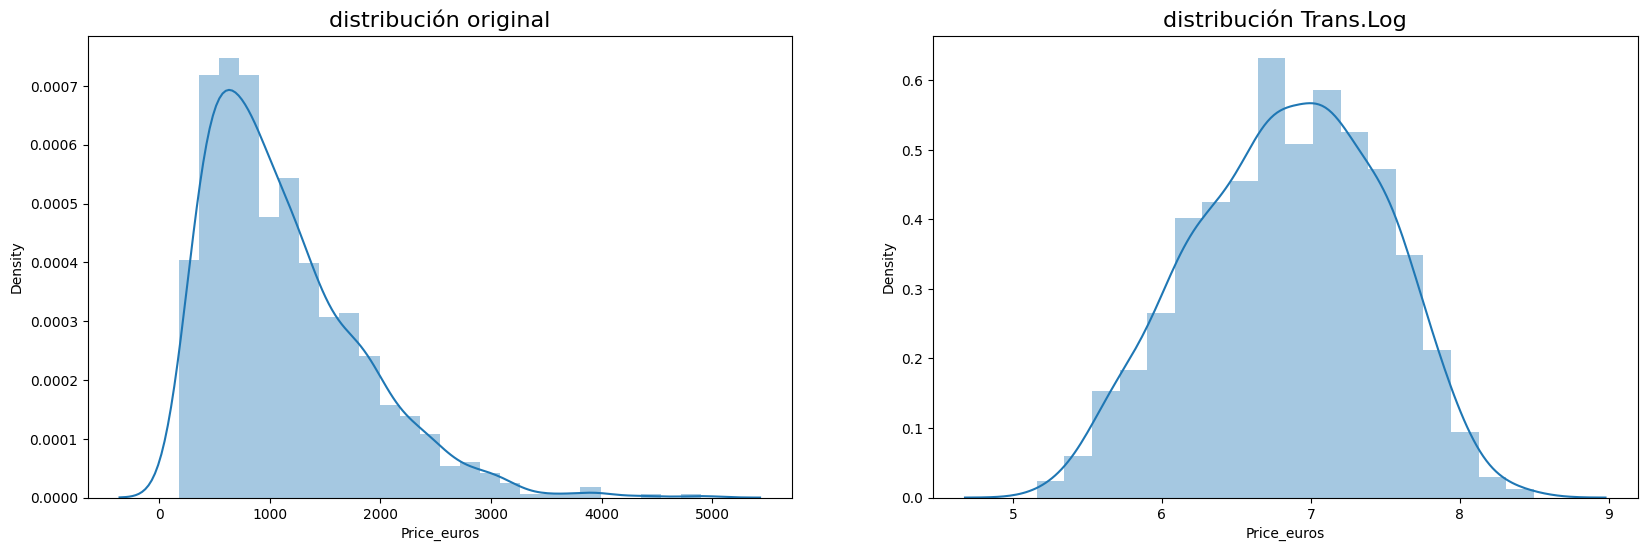

In [23]:
fig,ax=plt.subplots(1,2,figsize=(20,6))
g1=sns.distplot(train["Price_euros"],ax=ax[0])
g2=sns.distplot(np.log(train['Price_euros']),ax=ax[1])
ax[0].set_title("distribución original",fontsize=16)
ax[1].set_title("distribución Trans.Log",fontsize=16);

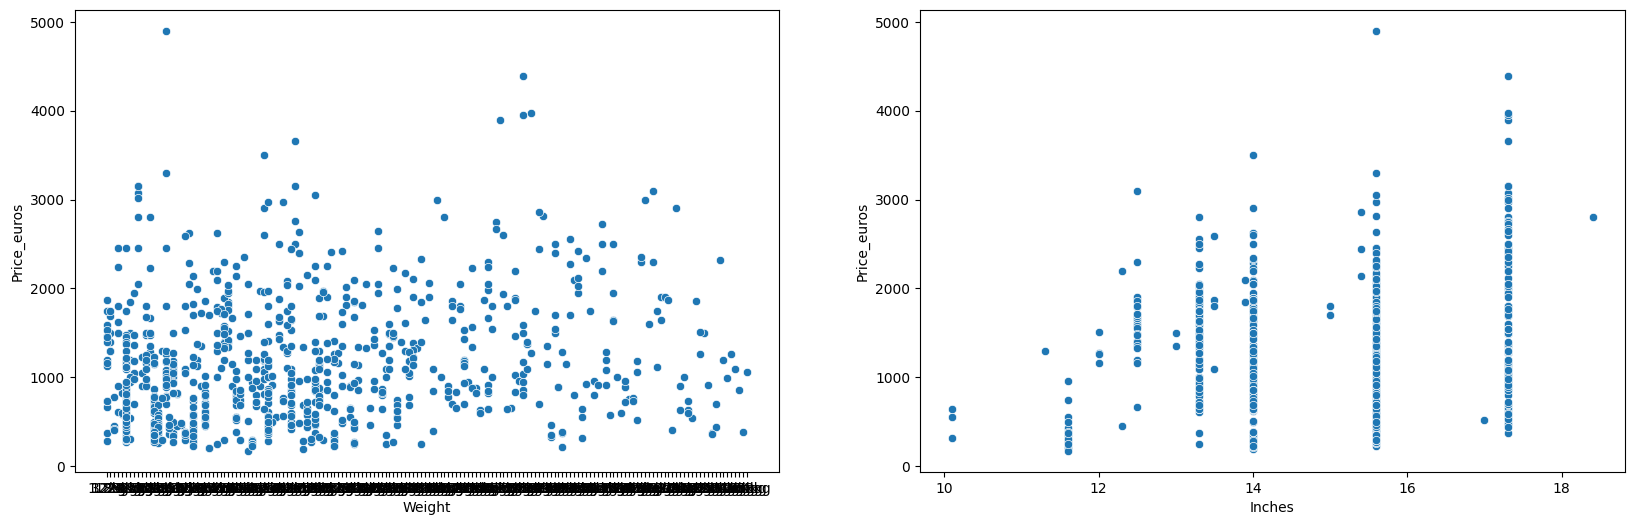

In [24]:
fig,ax=plt.subplots(1,2,figsize=(20,6))
g1=sns.scatterplot(x=train['Weight'],y=train['Price_euros'],ax=ax[0])
g2=sns.scatterplot(x=train['Inches'],y=train['Price_euros'],ax=ax[1]);




In [25]:
train.shape

(912, 13)

## Data processing

In [26]:
#transformamos peso
train['Weight'] = train['Weight'].str.replace('kg','').astype(float)
train['Ram'] = train['Ram'].str.replace('GB','').astype(float)

#df axuliar para screenresolution
df_scresolution = pd.DataFrame(train['ScreenResolution'].unique(), columns=['ScreenResolution'])


df_scresolution['Touch']=df_scresolution['ScreenResolution'].apply(lambda x:1 if 'Touchscreen' in x else 0)
df_scresolution['IPS']=df_scresolution['ScreenResolution'].apply(lambda x:1 if 'IPS' in x else 0)

df_scresolution['List_ori']=df_scresolution['ScreenResolution'].str.split().to_list()
df_scresolution['Resolucion']=df_scresolution['List_ori'].apply(lambda x:x[-1])
df_scresolution['Reso_ancho']=df_scresolution['List_ori'].apply(lambda x:x[-1]).str.split('x').to_list()
df_scresolution['Reso_ancho']=df_scresolution['List_ori'].apply(lambda x:x[-1].split('x')[0])
df_scresolution['Reso_alto']=df_scresolution['List_ori'].apply(lambda x:x[-1].split('x')[1])
df_scresolution['Reso_ancho']=df_scresolution['Reso_ancho'].astype('int')
df_scresolution['Reso_alto']=df_scresolution['Reso_alto'].astype('int')

df_scresolution=df_scresolution.drop(['List_ori'],axis=1)

train=train.merge(df_scresolution)



#df axuliar para Cpu
df_cpu = pd.DataFrame(train['Cpu'].unique(), columns=['Cpu'])

df_cpu['list_CPU']=df_cpu['Cpu'].str.split().to_list()

df_cpu['fab_CPU']=df_cpu['list_CPU'].apply(lambda x:x[0])
df_cpu['tipo_CPU']=train['Cpu'].apply(lambda x:" ".join(x.split()[0:3]))
df_cpu['CPU_GHz']=df_cpu['list_CPU'].apply(lambda x:float(x[-1].replace('GHz','')))


df_cpu=df_cpu.drop(['list_CPU'],axis=1)


train=train.merge(df_cpu)

#df axuliar para Memory

df_memo = pd.DataFrame(train['Memory'].unique(), columns=['Memory'])

df_memo['Memory']=df_memo['Memory'].apply(lambda x:x.replace('Flash Storage','Flash_Storage') if 'Flash Storage' in x else x)


df_memo['list_memo']=df_memo['Memory'].str.split().to_list()

df_memo['uni_memo']=0
df_memo['tipo_memo']=''
df_memo['memo_aux']=0

for i in range(0,df_memo['Memory'].shape[0]):
    df_memo['tipo_memo'][i]=df_memo['list_memo'][i][-1]
    
    if df_memo['list_memo'][i][-2][-2:]=='GB':
        df_memo['uni_memo'][i]=float(df_memo['list_memo'][i][-2][0:-2])
    else:df_memo['uni_memo'][i]=float(df_memo['list_memo'][i][-2][0:-2])*1024
    
    if len(df_memo['list_memo'][i])>2:
            if df_memo['list_memo'][i][0][-2:]=='GB':
                 df_memo['memo_aux'][i]=float(df_memo['list_memo'][i][0][0:-2])
            else:df_memo['memo_aux'][i]=float(df_memo['list_memo'][i][0][0:-2])*1024
     

df_memo['Memory']=df_memo['Memory'].apply(lambda x:x.replace('Flash_Storage','Flash Storage') if 'Flash_Storage' in x else x)

df_memo=df_memo.drop(['list_memo'],axis=1)    
    


train=train.merge(df_memo)


#df axuliar para GPU

df_gpu = pd.DataFrame(train['Gpu'].unique(), columns=['Gpu'])

df_gpu['list_gpu']=df_gpu['Gpu'].str.split().to_list()

df_gpu['fab_GPU']=df_gpu['list_gpu'].apply(lambda x: x[0])





df_gpu=df_gpu.drop(['list_gpu'],axis=1)


train=train.merge(df_gpu)



#df axuliar para OPsys
df_OpSys = pd.DataFrame(train['OpSys'].unique(), columns=['OpSys'])

df_OpSys['list_OpSys']=df_OpSys['OpSys'].str.split().to_list()

df_OpSys['fab_OpSys_code']=0

for i in range(len(df_OpSys['list_OpSys'])):
    
    if 'Wind' in df_OpSys['list_OpSys'][i][0]:
        df_OpSys['fab_OpSys_code'][i]= 1
    elif 'mac' in df_OpSys['list_OpSys'][i][0].lower():
        df_OpSys['fab_OpSys_code'][i]= 2




df_OpSys=df_OpSys.drop(['list_OpSys'],axis=1)

train=train.merge(df_OpSys)

#transformaciones


train['ppi']=(((train['Reso_ancho']**2)+(train['Reso_alto']**2))**0.5)/train['Inches']


train['TypeName_Code']= train['TypeName'].astype('category').cat.codes


train['Resolucion_Code']= train['Resolucion'].astype('category').cat.codes



train['Company_Code']= train['Company'].astype('category').cat.codes


train['fab_CPU_Code']= train['fab_CPU'].astype('category').cat.codes



train['fab_GPU_Code']= train['fab_GPU'].astype('category').cat.codes



train['tipo_memo_Code']= train['tipo_memo'].astype('category').cat.codes



train['tipo_CPU_Code']= train['tipo_CPU'].astype('category').cat.codes

In [27]:
df=train[[ 'Inches','Ram','Weight', 'Touch', 'IPS', 'Reso_ancho', 'Reso_alto',
       'CPU_GHz', 'uni_memo', 'tipo_memo_Code',
       'memo_aux', 'fab_OpSys_code', 'ppi', 'TypeName_Code',
       'Resolucion_Code', 'Company_Code', 'fab_CPU_Code', 'fab_GPU_Code',
       'tipo_CPU_Code','Price_euros']]

KeyError: "['fab_OpSys_code'] not in index"

In [ ]:
train.shape

(912, 27)

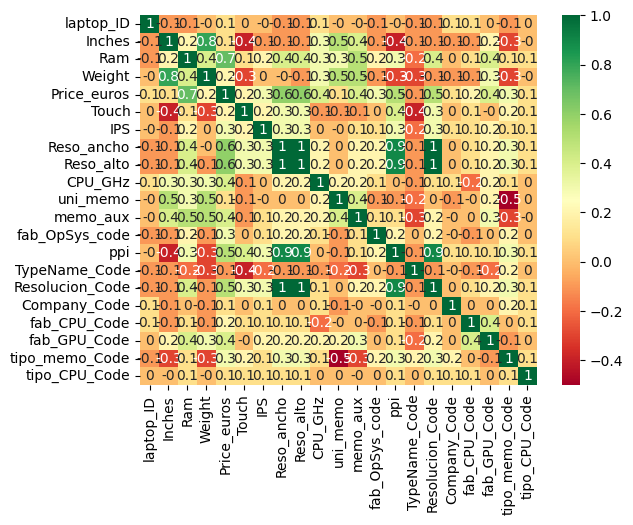

In [ ]:

correlation_matrix = train.corr().round(1)
sns.heatmap(data=correlation_matrix,cmap= 'RdYlGn', annot=True);

In [ ]:
df.corr()['Price_euros'].sort_values(ascending=False)

Price_euros        1.000000
Ram                0.726410
Reso_ancho         0.554760
Reso_alto          0.552809
Resolucion_Code    0.533225
ppi                0.473451
CPU_GHz            0.410933
fab_GPU_Code       0.378666
memo_aux           0.369880
fab_OpSys_code     0.302425
tipo_memo_Code     0.290082
IPS                0.283899
Weight             0.210329
fab_CPU_Code       0.191199
Touch              0.155674
Company_Code       0.132781
uni_memo           0.088570
tipo_CPU_Code      0.072143
Inches             0.070152
TypeName_Code     -0.121573
Name: Price_euros, dtype: float64

In [ ]:
df.drop('Price_euros',axis=1)

,Inches,Ram,Weight,Touch,IPS,Reso_ancho,Reso_alto,CPU_GHz,uni_memo,tipo_memo_Code,memo_aux,fab_OpSys_code,ppi,TypeName_Code,Resolucion_Code,Company_Code,fab_CPU_Code,fab_GPU_Code,tipo_CPU_Code
0,12.5,4.0,1.20,1,0,1920,1080,0.9,64,0,0,0,176.232574,0,3,2,1,1,7
1,12.5,8.0,1.20,0,0,1920,1080,1.2,64,0,0,0,176.232574,0,3,2,1,1,10
2,13.3,4.0,1.29,0,0,3200,1800,1.5,32,0,0,0,276.053530,3,13,7,1,1,9
3,11.6,8.0,1.40,1,0,1366,768,1.1,64,0,0,0,135.094211,0,0,7,1,1,8
4,11.6,2.0,1.30,0,0,1366,768,1.5,32,3,0,0,135.094211,2,0,0,1,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,13.3,8.0,1.37,0,1,2560,1600,2.9,512,3,0,2,226.983005,4,10,1,1,1,9
908,15.4,16.0,1.83,0,1,2880,1800,2.9,512,3,0,2,220.534624,4,12,1,1,0,10
909,13.3,8.0,1.37,0,1,2560,1600,2.0,256,3,0,2,226.983005,4,10,1,1,1,10
910,15.4,16.0,1.83,0,1,2880,1800,2.8,256,3,0,2,220.534624,4,12,1,1,0,8


In [ ]:
df.columns

Index(['Inches', 'Ram', 'Weight', 'Touch', 'IPS', 'Reso_ancho', 'Reso_alto',
       'CPU_GHz', 'uni_memo', 'tipo_memo_Code', 'memo_aux', 'fab_OpSys_code',
       'ppi', 'TypeName_Code', 'Resolucion_Code', 'Company_Code',
       'fab_CPU_Code', 'fab_GPU_Code', 'tipo_CPU_Code', 'Price_euros'],
      dtype='object')

In [ ]:
import itertools


l=['Inches', 'Ram', 'Weight', 'Touch', 'IPS', 'Reso_ancho', 'Reso_alto',
       'CPU_GHz', 'uni_memo', 'tipo_memo_Code', 'memo_aux', 'fab_OpSys_code',
       'ppi', 'TypeName_Code', 'Resolucion_Code', 'Company_Code',
       'fab_CPU_Code', 'fab_GPU_Code', 'tipo_CPU_Code']

c = list(itertools.combinations(l, 2))

def powerset(list_name):
    s = list(list_name)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(10,len(s)+1))

l_max=[]
for x in powerset(l):
    l_max.append(list(x))



In [ ]:
len(l)

19

In [ ]:
len(l_max)

262144

-----------------------------------------------------------------------------------------------------------------

In [ ]:
def dame_todo(UF):
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error
    from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
    Mae_list=[]
    for i in range(0,len(UF)):
        X =train[UF[i]]
        y = np.log(train['Price_euros'])
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5)
        
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_scal = scaler.transform(X_train)
        X_test_scal = scaler.transform(X_test)

        lin_model = LinearRegression()
        lin_model.fit(X_train_scal, y_train)
        predictions = lin_model.predict(X_test_scal)
        Mae_list.append(mean_absolute_error(y_test, predictions))
    return Mae_list

#all_resul=dame_todo(l_max)       

In [ ]:
minimo_mae=min(all_resul)
all_resul.index(minimo_mae)
best_list=l_max[all_resul.index(minimo_mae)]


In [ ]:
best_list=['Ram',
 'Touch',
 'CPU_GHz',
 'tipo_memo_Code',
 'memo_aux',
 'fab_OpSys_code',
 'ppi',
 'TypeName_Code',
 'Resolucion_Code',
 'Company_Code',
 'fab_CPU_Code',
 'fab_GPU_Code']

['Ram',
 'Touch',
 'CPU_GHz',
 'tipo_memo_Code',
 'memo_aux',
 'fab_OpSys_code',
 'ppi',
 'TypeName_Code',
 'Resolucion_Code',
 'Company_Code',
 'fab_CPU_Code',
 'fab_GPU_Code']

## Pasos que si o si debéis realizar para poder participar en la competición:

### 1. Definir X e y

In [ ]:
X =df[best_list]
y = np.log(df['Price_euros'])
X.shape

(912, 12)

In [ ]:
y.shape

(912,)

### 2. Dividir X_train, X_test, y_train, y_test

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 2)

In [ ]:
X_train

,Ram,Touch,CPU_GHz,tipo_memo_Code,memo_aux,fab_OpSys_code,ppi,TypeName_Code,Resolucion_Code,Company_Code,fab_CPU_Code,fab_GPU_Code
304,8.0,0,2.5,3,0,1,141.211998,3,3,10,1,1
409,8.0,0,1.6,3,0,1,141.211998,3,3,4,1,2
146,4.0,1,2.5,3,0,1,157.350512,0,3,10,1,1
530,8.0,0,2.5,1,128,1,141.211998,1,3,10,1,2
456,16.0,0,2.8,3,0,1,157.350512,1,3,14,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...
534,8.0,0,1.8,3,0,1,141.211998,3,3,4,1,0
584,8.0,0,2.7,3,0,1,141.211998,3,3,4,1,0
493,8.0,0,2.8,3,0,1,209.800683,4,9,10,1,2
527,8.0,0,2.5,1,128,1,127.335675,1,3,11,1,2


### 3. Asignar el modelo (vacío) a una variable


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error



In [ ]:
lin_model = LinearRegression()


In [ ]:
lin_model.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred_lin = lin_model.predict(X_test)
mean_absolute_error(y_pred_lin, y_test)

0.252775539756945

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler

scaler = StandardScaler()

scaler.fit(X_train)
X_train_scal = scaler.transform(X_train)
X_test_scal = scaler.transform(X_test)
n_alphas = 100
alphas = np.logspace(-4, 3, n_alphas) 

err_lasso = []

for a in alphas:
    lasso = Lasso(alpha=a)
    lasso.fit(X_train_scal, y_train)
    
    y_pred = lasso.predict(X_test_scal)
    lasso_error = mean_absolute_error(y_pred, y_test)
    err_lasso.append(lasso_error)

In [ ]:
np.min(err_lasso)

0.2520836425525168

In [ ]:
alphas[err_lasso.index(np.min(err_lasso))]

0.0049770235643321085

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
lasso = Lasso()
lasso.fit(X_train_scal, y_train)
alphas = np.logspace(-4, 3, n_alphas) 


parameters =[{"alpha": alphas}]

Lasso_gs = GridSearchCV(lasso, parameters, cv=5, scoring="neg_mean_absolute_error")

Lasso_gs.fit(X_train_scal, y_train)

print(Lasso_gs.best_params_)
print(Lasso_gs.best_score_)

{'alpha': 0.0015922827933410922}
-0.2537941605635163


In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly_reg = PolynomialFeatures(degree=2)
poly_reg.fit(X_train_scal)
X_train_poly = poly_reg.transform(X_train_scal)

pol_reg_2 = LinearRegression()
pol_reg_2.fit(X_train_poly, y_train)

LinearRegression()

In [ ]:
X_test_poly = poly_reg.transform(X_test)
predictions = pol_reg_2.predict(X_test_poly)

In [ ]:
print("MAE test", mean_absolute_error(y_test, predictions))

MAE test 17884237638824.324


### 4. Sacar métricas, valorar el modelo 

Recuerda que en la competición se va a evaluar con la métrica de MAE.

In [ ]:
predictions = lin_model.predict(X_test)
print("MAE test", mean_absolute_error(y_test, predictions))

NameError: name 'lin_model' is not defined

-----------------------------------------------------------------

## Una vez listo el modelo, toca predecir con el dataset de predicción 

Definición de **modelo que está listo**. 

Tras hacer suficientes pruebas, analizar los datos, hacer feature engineering, probar diferentes modelos con diferentes parámetros, es con este con el que observo mejores métricas y menos overfitting. ¡Cuidado con el overfitting aquí! Si vuestro modelo aprende muy bien de estos datos pero hay overfitting cuando le pasemos los datos desconocidos de `test.csv` nos arriesgamos a que digamos, no salga lo esperado.

### 1. Entrena dicho modelo con TODOS tus datos de train, esto es con `train.csv` al completo.


**CON LAS TRANSFORMACIONES QUE LE HAYAS REALIZADO A `X` INCLUÍDAS.**


Véase:
- Estandarización/Normalización
- Eliminación de Outliers
- Eliminación de columnas
- Creación de columnas nuevas
- Gestión de valores nulos
- Y un largo etcétera de técnicas que como Data Scientist hayas considerado las mejores para tu dataset.

### 2. Carga los datos de `test.csv` para predecir.

In [ ]:
X_pred = pd.read_csv("data\\test.csv", index_col = 0)
X_pred_original=X_pred
train=X_pred

In [ ]:
#transformamos peso
train['Weight'] = train['Weight'].str.replace('kg','').astype(float)
train['Ram'] = train['Ram'].str.replace('GB','').astype(float)

#df axuliar para screenresolution
df_scresolution = pd.DataFrame(train['ScreenResolution'].unique(), columns=['ScreenResolution'])


df_scresolution['Touch']=df_scresolution['ScreenResolution'].apply(lambda x:1 if 'Touchscreen' in x else 0)
df_scresolution['IPS']=df_scresolution['ScreenResolution'].apply(lambda x:1 if 'IPS' in x else 0)

df_scresolution['List_ori']=df_scresolution['ScreenResolution'].str.split().to_list()
df_scresolution['Resolucion']=df_scresolution['List_ori'].apply(lambda x:x[-1])
df_scresolution['Reso_ancho']=df_scresolution['List_ori'].apply(lambda x:x[-1]).str.split('x').to_list()
df_scresolution['Reso_ancho']=df_scresolution['List_ori'].apply(lambda x:x[-1].split('x')[0])
df_scresolution['Reso_alto']=df_scresolution['List_ori'].apply(lambda x:x[-1].split('x')[1])
df_scresolution['Reso_ancho']=df_scresolution['Reso_ancho'].astype('int')
df_scresolution['Reso_alto']=df_scresolution['Reso_alto'].astype('int')

df_scresolution=df_scresolution.drop(['List_ori'],axis=1)

train=train.merge(df_scresolution)



#df axuliar para Cpu
df_cpu = pd.DataFrame(train['Cpu'].unique(), columns=['Cpu'])

df_cpu['list_CPU']=df_cpu['Cpu'].str.split().to_list()

df_cpu['fab_CPU']=df_cpu['list_CPU'].apply(lambda x:x[0])
df_cpu['tipo_CPU']=train['Cpu'].apply(lambda x:" ".join(x.split()[0:3]))
df_cpu['CPU_GHz']=df_cpu['list_CPU'].apply(lambda x:float(x[-1].replace('GHz','')))


df_cpu=df_cpu.drop(['list_CPU'],axis=1)


train=train.merge(df_cpu)

#df axuliar para Memory

df_memo = pd.DataFrame(train['Memory'].unique(), columns=['Memory'])

df_memo['Memory']=df_memo['Memory'].apply(lambda x:x.replace('Flash Storage','Flash_Storage') if 'Flash Storage' in x else x)


df_memo['list_memo']=df_memo['Memory'].str.split().to_list()

df_memo['uni_memo']=0
df_memo['tipo_memo']=''
df_memo['memo_aux']=0

for i in range(0,df_memo['Memory'].shape[0]):
    df_memo['tipo_memo'][i]=df_memo['list_memo'][i][-1]
    
    if df_memo['list_memo'][i][-2][-2:]=='GB':
        df_memo['uni_memo'][i]=float(df_memo['list_memo'][i][-2][0:-2])
    else:df_memo['uni_memo'][i]=float(df_memo['list_memo'][i][-2][0:-2])*1024
    
    if len(df_memo['list_memo'][i])>2:
            if df_memo['list_memo'][i][0][-2:]=='GB':
                 df_memo['memo_aux'][i]=float(df_memo['list_memo'][i][0][0:-2])
            else:df_memo['memo_aux'][i]=float(df_memo['list_memo'][i][0][0:-2])*1024
     

df_memo['Memory']=df_memo['Memory'].apply(lambda x:x.replace('Flash_Storage','Flash Storage') if 'Flash_Storage' in x else x)

df_memo=df_memo.drop(['list_memo'],axis=1)    
    


train=train.merge(df_memo)


#df axuliar para GPU

df_gpu = pd.DataFrame(train['Gpu'].unique(), columns=['Gpu'])

df_gpu['list_gpu']=df_gpu['Gpu'].str.split().to_list()

df_gpu['fab_GPU']=df_gpu['list_gpu'].apply(lambda x: x[0])





df_gpu=df_gpu.drop(['list_gpu'],axis=1)


train=train.merge(df_gpu)



#df axuliar para OPsys
df_OpSys = pd.DataFrame(train['OpSys'].unique(), columns=['OpSys'])

df_OpSys['list_OpSys']=df_OpSys['OpSys'].str.split().to_list()

df_OpSys['fab_OpSys_code']=0

for i in range(len(df_OpSys['list_OpSys'])):
    
    if 'Wind' in df_OpSys['list_OpSys'][i][0]:
        df_OpSys['fab_OpSys_code'][i]= 1
    elif 'mac' in df_OpSys['list_OpSys'][i][0].lower():
        df_OpSys['fab_OpSys_code'][i]= 2




df_OpSys=df_OpSys.drop(['list_OpSys'],axis=1)

train=train.merge(df_OpSys)

#transformaciones


train['ppi']=(((train['Reso_ancho']**2)+(train['Reso_alto']**2))**0.5)/train['Inches']


train['TypeName_Code']= train['TypeName'].astype('category').cat.codes


train['Resolucion_Code']= train['Resolucion'].astype('category').cat.codes



train['Company_Code']= train['Company'].astype('category').cat.codes


train['fab_CPU_Code']= train['fab_CPU'].astype('category').cat.codes



train['fab_GPU_Code']= train['fab_GPU'].astype('category').cat.codes



train['tipo_memo_Code']= train['tipo_memo'].astype('category').cat.codes



train['tipo_CPU_Code']= train['tipo_CPU'].astype('category').cat.codes

df=train

In [ ]:
X =df[best_list]

X.shape

(391, 12)

**¿Por qué da error?** 

In [ ]:
predictions_submit = lin_model.predict(X_pred[['laptop_ID','Inches',]])
predictions_submit

ValueError: X has 2 features, but LinearRegression is expecting 12 features as input.

IMPORTANTE: APLICAR LO MISMO A ESTOS DATOS QUE HAYÁIS APLICADO A LOS DATOS DE ENTRENAMIENTO

- SI EL ARRAY CON EL QUE HICISTEIS `.fit()` ERA DE 4 COLUMNAS, PARA `.predict()` DEBEN SER LAS MISMAS
- SI AL ARRAY CON EL QUE HICISTEIS `.fit()` LO NORMALIZASTEIS, PARA `.predict()` DEBÉIS NORMALIZARLO
- TODO IGUAL SALVO BORRAR FILAS, EL NÚMERO DE ROWS SE DEBE MANTENER EN ESTE SET, PUES LA PREDICCIÓN DEBE TENER 391 FILAS, SI O SI

**Entonces, si al cargar los datos de train usé `index_col=0` para que utilizara la primera columna del conjunto de datos como índice, ¿tendré que hacerlo también para el conjunto `test.csv`?**

In [ ]:
# ¿Qué opináis?
# Sí

![](https://www.tierraljelechu.com/web/img/wiki_up/1.996-SorpresaDto.-1-Red.jpg)

In [ ]:
'''X_pred = pd.read_csv("Dataset/test.csv", index_col=0)
X_pred.head()'''

'X_pred = pd.read_csv("Dataset/test.csv", index_col=0)\nX_pred.head()'

### 3. AHORA puedo hacer la predicción que será lo que subirás a Kaggle. 

**¿Qué es lo que subirás a Kaggle?**

In [ ]:
'''predictions_submit = model.predict(X_pred)
predictions_submit'''

'predictions_submit = model.predict(X_pred)\npredictions_submit'

**¡PERO! Para subir a Kaggle la predicción, ésta tendrá que tener una forma específica y no valdrá otra.**

En este caso, la **MISMA** forma que `sample_submission.csv`. 

In [ ]:
sample = pd.read_csv("data\\sample_submission.csv")

In [ ]:
sample.head()

,id,Price_euros
0,824,496.0
1,101,1948.5
2,1157,947.5
3,940,621.0
4,853,1032.5


In [ ]:
sample.shape

(391, 2)

### 4. Mete tus predicciones en un dataframe. 

En este caso, la **MISMA** forma que `sample_submission.csv`. 

In [ ]:
X_pred_original.index

Int64Index([ 824,  101, 1157,  940,  853,  650,  317,  217,  489, 1245,
            ...
            1081,  945,  334,  550, 1148,  292,  688,  910,   54, 1167],
           dtype='int64', name='id', length=391)

In [ ]:
submission = pd.DataFrame({"id": X_pred_original.index, "Price_euros": predictions_submit})

In [ ]:
submission.head()

,id,Price_euros
0,824,1214.976803
1,101,1093.133659
2,1157,1265.246952
3,940,1202.467714
4,853,1219.533454


In [ ]:
submission.shape

(391, 2)

### 5. Pásale el CHEQUEATOR para comprobar que efectivamente está listo para subir a Kaggle.

In [ ]:
def chequeator(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.id.all() == sample.id.all():
                print("You're ready to submit!")
                submission.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://i.kym-cdn.com/photos/images/facebook/000/747/556/27a.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("\nMensaje secreto de Miguel: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `laptops_test.csv`. Lloro.")


In [ ]:
chequeator(submission)

You're ready to submit!
